# Basic setup

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import os
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
from natsort import natsorted, ns
import glob
from pymer4.models import Lmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
%load_ext rpy2.ipython

fpath = 'where/you/have/the/data'

In [3]:
%%R
library('lme4')
library('lmerTest')
library('lsmeans')

# Patient - Interaction - Overall pain rating

In [4]:
pat_data = pd.read_csv(os.path.join(fpath,'study2_pat_interaction_rating_data.csv'))
pat_mean = pat_data.groupby(['DyadID','Condition','Counterbalance','block'])['Pain_Rating'].mean().reset_index()

In [5]:
pat_data['trials_c'] = pat_data.Trials - pat_data.Trials.mean()

In [9]:
%%R -i pat_data
pat_data$Site <- factor(pat_data$Site)
pat_data$Temperature <- factor(pat_data$Temperature)
pat_data$Counterbalance <- factor(pat_data$Counterbalance)
pat_data$Condition <- factor(pat_data$Condition_new)
pat_data$Experimenter <- factor(pat_data$Experimenter)
pat_data$CurrentColor <- factor(pat_data$Current_Color)
docpat_overall_m <- lmer(Pain_Rating ~ Site + CurrentColor + trials_c 
                         + Experimenter*Condition + Temperature*Condition + Counterbalance*Condition
                         + (1 + trials_c + Condition | DyadID), data = pat_data)

anova(docpat_overall_m)

Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
                          Sum Sq Mean Sq NumDF  DenDF F.value   Pr(>F)   
Site                      346.28  115.43     3 587.63  1.2696 0.283904   
CurrentColor               13.80   13.80     1  38.00  0.1518 0.698990   
trials_c                  334.04  334.04     1  41.77  3.6743 0.062117 . 
Experimenter              282.28  282.28     1  39.03  3.1049 0.085887 . 
Condition                 309.09  309.09     1  37.94  3.3998 0.073026 . 
Temperature               727.20  727.20     1  39.12  7.9987 0.007344 **
Counterbalance            210.88  210.88     1  39.11  2.3195 0.135804   
Experimenter:Condition    145.20  145.20     1  38.13  1.5971 0.213988   
Condition:Temperature      37.72   37.72     1  38.08  0.4149 0.523358   
Condition:Counterbalance 1121.49 1121.49     1  38.10 12.3358 0.001162 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [11]:
%%R
lsmeans(docpat_overall_m,pairwise~Counterbalance*Condition)

$lsmeans
 Counterbalance Condition   lsmean       SE    df  lower.CL upper.CL
 1              0         24.32855 3.493970 44.52 17.289256 31.36784
 2              0         22.49142 3.182443 43.83 16.079758 28.90307
 1              1         26.58101 3.750677 42.46 19.024528 34.13748
 2              1         15.14350 3.393919 42.12  8.305779 21.98121

Results are averaged over the levels of: Site, CurrentColor, Experimenter, Temperature 
Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 

$contrasts
 contrast   estimate       SE    df t.ratio p.value
 1,0 - 2,0  1.837131 4.330735 39.19   0.424  0.9740
 1,0 - 1,1 -2.252459 2.045112 38.47  -1.101  0.6908
 1,0 - 2,1  9.185051 4.546124 46.68   2.020  0.1952
 2,0 - 1,1 -4.089590 4.597425 46.29  -0.890  0.8103
 2,0 - 2,1  7.347919 1.836237 38.46   4.002  0.0015
 1,1 - 2,1 11.437509 4.792244 39.16   2.387  0.0964

Results are averaged over the levels of: Site, CurrentColor, Experimenter, Temperature 
P value adjustment: t

In [12]:
pat_mean_counter1 = pat_mean[pat_mean['Counterbalance']==1]
pat_mean_counter2 = pat_mean[pat_mean['Counterbalance']==2]

## Figure 3(C-3)

[Text(0,0,'Thermedol'), Text(1,0,'Control')]

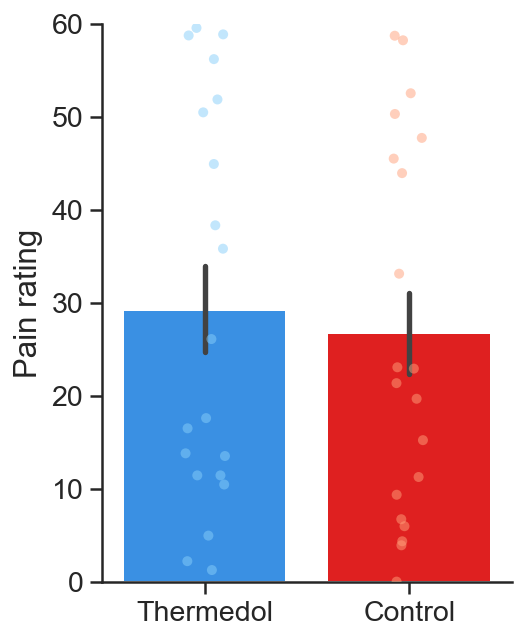

In [8]:
sns.set(style="ticks", font_scale=1.3)
g = sns.catplot(x="Condition", y="Pain_Rating", order = ["Thermedol","Vaseline"],
                   palette={'Thermedol':'dodgerblue','Vaseline':'red'},units='DyadID',
                   kind="bar",n_boot=5000, ci=68, aspect=.8, data=pat_mean_counter1)

g = sns.stripplot(x="Condition", y="Pain_Rating", palette={'Thermedol':'lightskyblue','Vaseline':'lightsalmon'},
                   data=pat_mean_counter1, order=['Thermedol','Vaseline'],alpha=.5)

g.set(ylim=(0, 60))
plt.ylabel('Pain rating')
plt.xlabel('')
g.set_xticklabels(["Thermedol","Control"])

## Figure 3(B-3)

[Text(0, 0, 'Control'), Text(1, 0, 'Thermedol')]

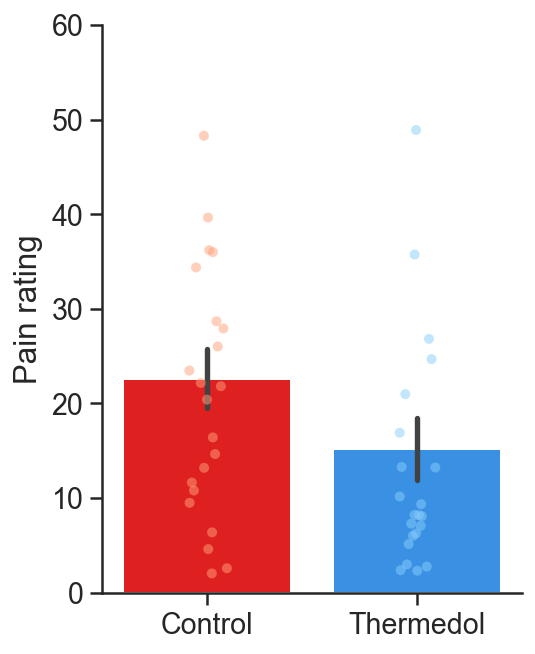

In [13]:
sns.set(style="ticks", font_scale=1.3)
g = sns.catplot(x="Condition", y="Pain_Rating", order = ["Vaseline","Thermedol"],
                   palette={'Thermedol':'dodgerblue','Vaseline':'red'},units='DyadID',
                   kind="bar",n_boot=5000, ci=68, aspect=.8, data=pat_mean_counter2)

g = sns.stripplot(x="Condition", y="Pain_Rating", palette={'Thermedol':'lightskyblue','Vaseline':'lightsalmon'},
                   data=pat_mean_counter2, order=["Vaseline","Thermedol"],alpha=.5)

g.set(ylim=(0, 60))
plt.ylabel('Pain rating')
plt.xlabel('')
g.set_xticklabels(["Control","Thermedol"])

# Patient - Interaction - Beliefs of effectiveness

In [14]:
pat_q = pd.read_csv(os.path.join(fpath,'study2_pat_interaction_belief_data.csv'))

In [17]:
%%R -i pat_q
pat_q$Time <- factor(pat_q$Time_new)
pat_q$Counterbalance <- factor(pat_q$Counterbalance)
pat_q$Condition <- factor (pat_q$Condition_new)
pat_q$Temperature <- factor (pat_q$Temperature)
pat_q$Experimenter <- factor (pat_q$Experimenter)
effectivness_model <- lmer(effectiveness ~  Experimenter + Temperature + Time*Condition*Counterbalance 
                           +  (1 + Time + Condition | DyadID), data = pat_q)
anova(effectivness_model)

Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
                              Sum Sq Mean Sq NumDF  DenDF F.value   Pr(>F)   
Experimenter                   311.6   311.6     1 39.799  0.7458 0.392999   
Temperature                    884.7   884.7     1 39.799  2.1170 0.153511   
Time                            82.2    82.2     1 41.032  0.1968 0.659681   
Condition                      483.3   483.3     1 66.508  1.1565 0.286070   
Counterbalance                  27.7    27.7     1 38.841  0.0664 0.798029   
Time:Condition                 797.5   797.5     1 81.575  1.9083 0.170921   
Time:Counterbalance            129.1   129.1     1 41.032  0.3090 0.581325   
Condition:Counterbalance      1917.4  1917.4     1 66.508  4.5883 0.035857 * 
Time:Condition:Counterbalance 4175.6  4175.6     1 81.575  9.9921 0.002207 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [18]:
%%R
lsmeans(effectivness_model,pairwise~Time*Condition*Counterbalance)

$lsmeans
 Time Condition Counterbalance   lsmean       SE    df lower.CL upper.CL
 1    0         1              36.54516 5.097639 61.97 26.35502 46.73531
 2    0         1              46.63781 6.140786 54.72 34.36242 58.91320
 1    1         1              38.66321 5.603580 59.03 27.46170 49.86473
 2    1         1              37.63320 6.543985 51.25 24.55182 50.71458
 1    0         2              43.25806 4.669233 60.41 33.92429 52.59183
 2    0         2              28.55363 5.656495 53.16 17.24633 39.86092
 1    1         2              39.44951 5.148759 57.51 29.15717 49.74184
 2    1         2              53.13576 6.036830 49.83 41.06818 65.20334

Results are averaged over the levels of: Experimenter, Temperature 
Degrees-of-freedom method: satterthwaite 
Confidence level used: 0.95 

$contrasts
 contrast         estimate       SE     df t.ratio p.value
 1,0,1 - 2,0,1 -10.0926450 8.054496  79.90  -1.253  0.9130
 1,0,1 - 1,1,1  -2.1180500 6.572054  82.66  -0.322  1.0000
 1,0,

## Figure 3(C-2)

In [19]:
pat_q_t1 = pat_q[pat_q['Time_new']==1]
pat_q_t2 = pat_q[pat_q['Time_new']==2]

In [20]:
effectiveness_diff = pat_q_t2.effectiveness.values - pat_q_t1.effectiveness.values

In [21]:
patient_belief_change = pd.DataFrame(effectiveness_diff)
patient_belief_change.columns = ['belief_change']

In [22]:
patient_belief_change['block'] = pat_q_t1['block'].values
patient_belief_change['Condition'] = pat_q_t1['Condition'].values
patient_belief_change['Counterbalance'] = pat_q_t1['Counterbalance'].values

In [23]:
patient_belief_change_T1C2 = patient_belief_change[patient_belief_change['Counterbalance']==1]
patient_belief_change_C1T2 = patient_belief_change[patient_belief_change['Counterbalance']==2]

[Text(0, 0, 'Thermedol'), Text(1, 0, 'Control')]

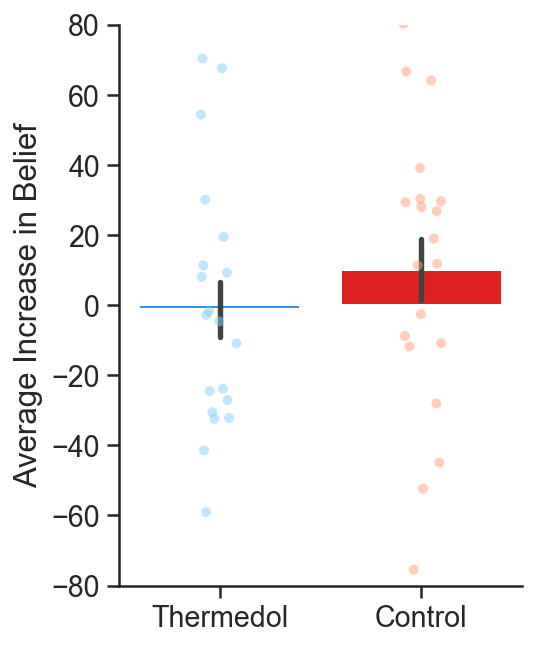

In [24]:
sns.set(style="ticks", font_scale=1.3)
g = sns.catplot(x="Condition", y="belief_change", order = ["Thermedol","Vaseline"],
                   palette={'Thermedol':'dodgerblue','Vaseline':'red'},
                   kind="bar",n_boot=5000, ci=68, aspect=.8, data=patient_belief_change_T1C2)

g = sns.stripplot(x="Condition", y="belief_change", palette={'Thermedol':'lightskyblue','Vaseline':'lightsalmon'},
                   data=patient_belief_change_T1C2, order=["Thermedol","Vaseline"],alpha=.5)

g.set(ylim=(-80, 80))
plt.ylabel('Average Increase in Belief')
plt.xlabel('')
g.set_xticklabels(["Thermedol","Control"])


## Figure 3(B-2)

[Text(0, 0, 'Control'), Text(1, 0, 'Thermedol')]

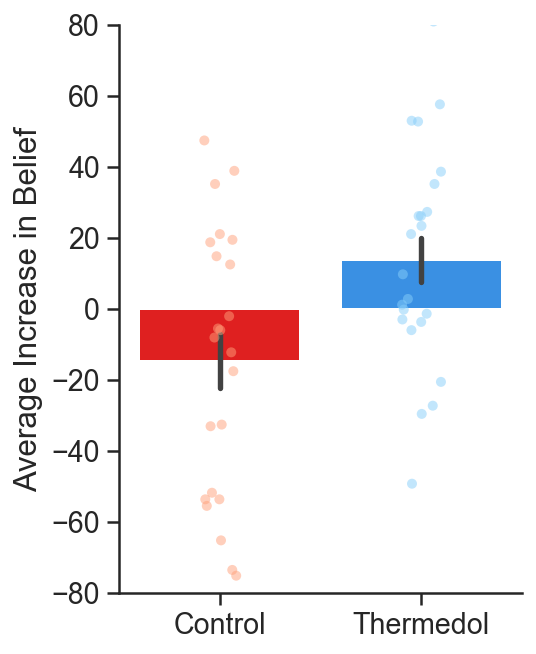

In [25]:
sns.set(style="ticks", font_scale=1.3)
g = sns.catplot(x="Condition", y="belief_change", order = ["Vaseline","Thermedol"],
                   palette={'Vaseline':'red','Thermedol':'dodgerblue'},
                   kind="bar",n_boot=5000, ci=68, aspect=.8, data=patient_belief_change_C1T2)

g = sns.stripplot(x="Condition", y="belief_change", palette={'Thermedol':'lightskyblue','Vaseline':'lightsalmon'},
                   data=patient_belief_change_C1T2, order=["Vaseline","Thermedol"],alpha=.5)

g.set(ylim=(-80, 80))
plt.ylabel('Average Increase in Belief')
plt.xlabel('')
g.set_xticklabels(["Control","Thermedol"])


# Doctor - Interaction - Beliefs of effectiveness

In [26]:
doc_q = pd.read_csv(os.path.join(fpath,'study2_doc_interaction_belief_data.csv'))

In [27]:
doc_q_pre = doc_q[doc_q["Time"]==1].reset_index(drop=True)

## Figure 3(A-2, right panel)

[Text(0, 0, 'Control'), Text(1, 0, 'Thermedol')]

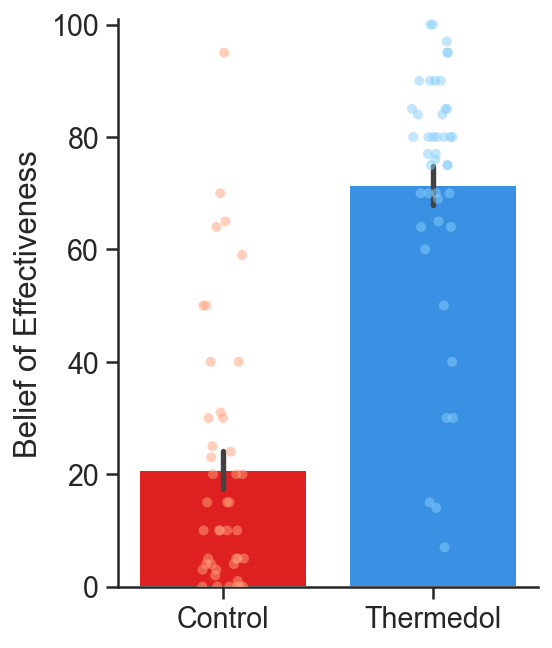

In [30]:
sns.set(style="ticks", font_scale=1.3)
g = sns.catplot(x="Condition", y="effectiveness", 
                palette={'Thermedol':'dodgerblue','Vaseline':'red'},units='DyadID',
                   n_boot=5000, ci=68, data=doc_q_pre, kind="bar", 
                order=['Vaseline','Thermedol'], aspect=.8)

g = sns.stripplot(x="Condition", y="effectiveness", 
                  palette={'Thermedol':'lightskyblue','Vaseline':'lightsalmon'},
                   data=doc_q_pre, order=['Vaseline','Thermedol'],alpha=.5)

g.set(ylim=(0, 101))
plt.ylabel('Belief of Effectiveness')
plt.xlabel('')
g.set_xticklabels(["Control","Thermedol"])

In [35]:
%%R -i doc_q
doc_q$Temperature <- factor(doc_q$Temperature)
doc_q$Experimenter <- factor(doc_q$Experimenter)
doc_q$Time <- factor(doc_q$Time)
doc_q$Counterbalance <- factor(doc_q$Counterbalance)
doc_q$Condition <- factor(doc_q$Condition_new)
effectivness_model <- lmer(effectiveness ~ Temperature + Experimenter + Time*Condition*Counterbalance + (1 + Time + Condition | DyadID)
                           , data = doc_q)
anova(effectivness_model)

Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
                               Sum Sq Mean Sq NumDF  DenDF F.value   Pr(>F)    
Temperature                       4.6     4.6     1 39.000   0.037   0.8485    
Experimenter                     18.8    18.8     1 39.000   0.152   0.6984    
Time                            106.6   106.6     1 41.000   0.864   0.3580    
Condition                     16983.9 16983.9     1 41.000 137.606 1.11e-14 ***
Counterbalance                    0.0     0.0     1 39.006   0.000   0.9852    
Time:Condition                   69.4    69.4     1 41.001   0.563   0.4575    
Time:Counterbalance               0.0     0.0     1 41.000   0.000   0.9869    
Condition:Counterbalance        168.7   168.7     1 41.000   1.367   0.2491    
Time:Condition:Counterbalance    87.0    87.0     1 41.001   0.705   0.4060    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
